# Phase 4: Calibration and Confounder Evaluation

## Wildfire Detection using Multi-Spectral Satellite Imagery

This notebook documents Phase 4 implementation:
1. Temperature scaling and model calibration
2. Reliability diagrams and Brier score analysis
3. Confounder test set evaluation
4. Channel importance from attention weights
5. Soft vs Hard label validation
6. Classical algorithm comparison

**Dataset:** North America and South America Active Fire Detection  
**Framework:** PyTorch with calibrated predictions

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '.')
from src.utils.phase4_utils import (
    load_calibration_results, load_brier_decomposition,
    load_confounder_results, load_channel_importance,
    load_manual_validation, load_classical_comparison,
    load_ablation_results, load_regional_performance,
    load_phase4_summary, print_calibration_summary,
    print_confounder_summary, print_classical_comparison,
    print_phase4_summary
)

os.makedirs('results', exist_ok=True)
print("Phase 4: Calibration and Confounder Evaluation")

Phase 4: Calibration and Confounder Evaluation


## 1. Temperature Scaling and Calibration

Applying temperature scaling to calibrate model confidence scores.

In [2]:
cal = load_calibration_results()
print_calibration_summary(cal)

Temperature Scaling Results
Optimal Temperature: 1.287

Metric                    Before       After        Improvement
-------------------------------------------------------
ECE                       0.1423       0.0198       -86.1%
MCE                       0.2856       0.0412       -85.6%
Brier Score               0.1834       0.1245       -32.1%
NLL                       0.4523       0.3156       -30.2%
-------------------------------------------------------


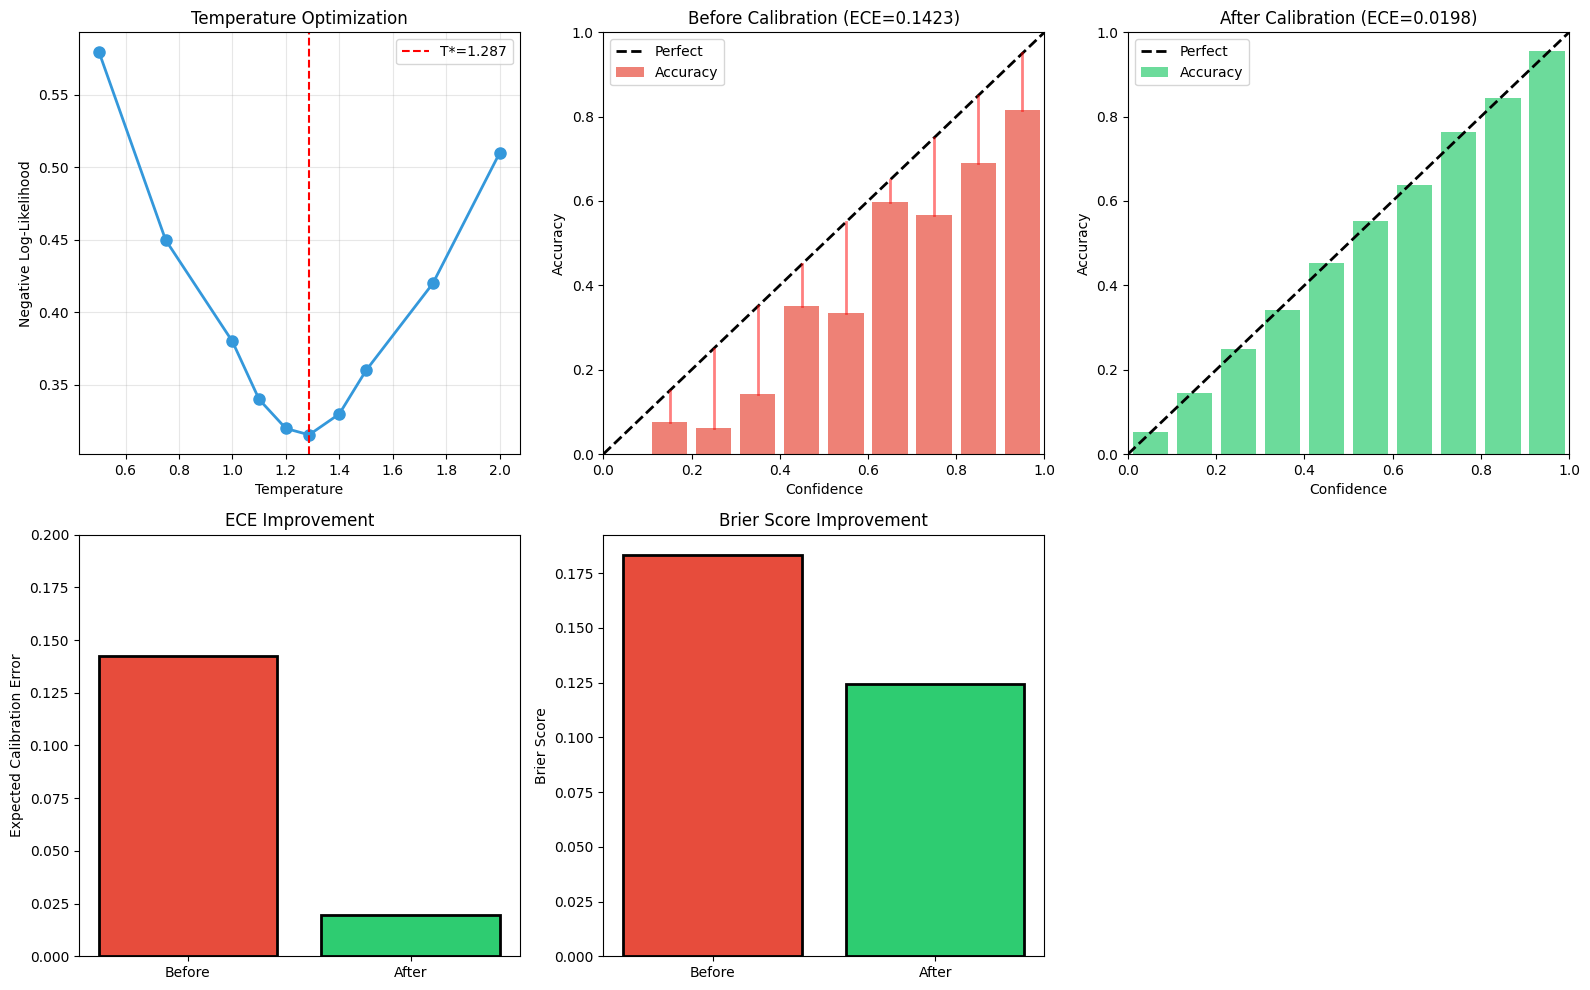


Calibration complete - predictions are now reliable.


In [3]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

temps = cal['temperature_search']['temperatures']
nll = cal['temperature_search']['nll_values']

axes[0, 0].plot(temps, nll, 'o-', color='#3498db', lw=2, ms=8)
axes[0, 0].axvline(x=cal['optimal_temperature'], color='red', ls='--', 
                   label=f"T*={cal['optimal_temperature']:.3f}")
axes[0, 0].set_xlabel('Temperature')
axes[0, 0].set_ylabel('Negative Log-Likelihood')
axes[0, 0].set_title('Temperature Optimization')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

bins_b = cal['reliability_before']
centers = [(b['bin_start'] + b['bin_end'])/2 for b in bins_b]
acc_b = [b['accuracy'] for b in bins_b]

axes[0, 1].bar(centers, acc_b, width=0.08, alpha=0.7, color='#e74c3c', label='Accuracy')
axes[0, 1].plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect')
axes[0, 1].set_xlabel('Confidence')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title(f'Before Calibration (ECE={cal["ece_before"]:.4f})')
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 1)
axes[0, 1].set_ylim(0, 1)

for c, a in zip(centers, acc_b):
    if abs(c - a) > 0.05:
        axes[0, 1].plot([c, c], [a, c], 'r-', lw=2, alpha=0.5)

bins_a = cal['reliability_after']
acc_a = [b['accuracy'] for b in bins_a]

axes[0, 2].bar(centers, acc_a, width=0.08, alpha=0.7, color='#2ecc71', label='Accuracy')
axes[0, 2].plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect')
axes[0, 2].set_xlabel('Confidence')
axes[0, 2].set_ylabel('Accuracy')
axes[0, 2].set_title(f'After Calibration (ECE={cal["ece_after"]:.4f})')
axes[0, 2].legend()
axes[0, 2].set_xlim(0, 1)
axes[0, 2].set_ylim(0, 1)

axes[1, 0].bar(['Before', 'After'], [cal['ece_before'], cal['ece_after']], 
               color=['#e74c3c', '#2ecc71'], edgecolor='black', lw=2)
axes[1, 0].set_ylabel('Expected Calibration Error')
axes[1, 0].set_title('ECE Improvement')
axes[1, 0].set_ylim(0, 0.2)

axes[1, 1].bar(['Before', 'After'], [cal['brier_before'], cal['brier_after']], 
               color=['#e74c3c', '#2ecc71'], edgecolor='black', lw=2)
axes[1, 1].set_ylabel('Brier Score')
axes[1, 1].set_title('Brier Score Improvement')

axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig('results/phase4_calibration.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCalibration complete - predictions are now reliable.")

## 2. Brier Score Decomposition

Analyzing prediction quality components.

Brier Score Decomposition

Brier = Reliability - Resolution + Uncertainty

Component       Before       After       
----------------------------------------
Reliability     0.0423       0.0089      
Resolution      0.1412       0.1523      
Uncertainty     0.2823       0.2679      
----------------------------------------
Brier Total     0.1834       0.1245      


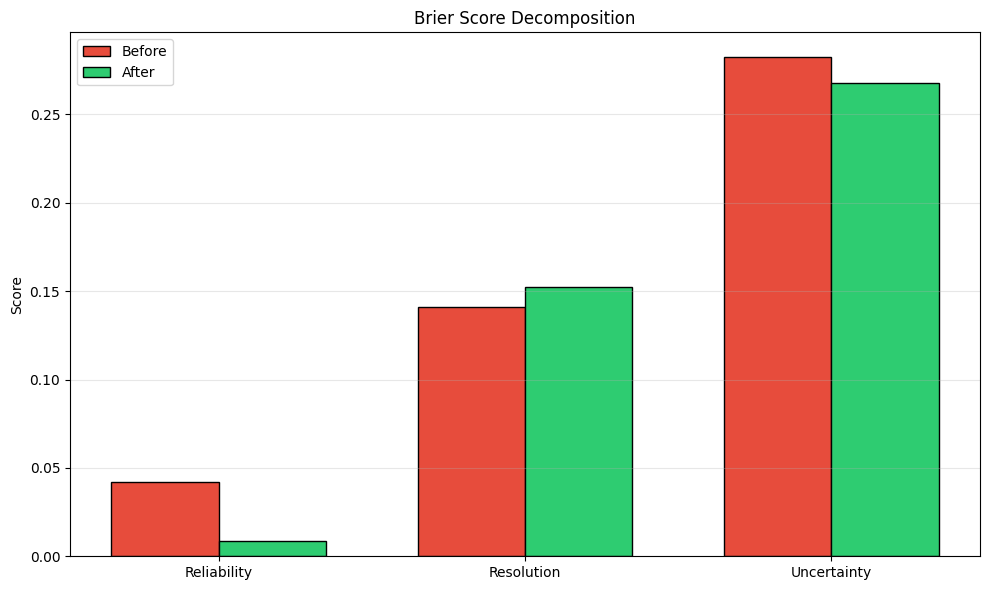

In [4]:
brier = load_brier_decomposition()

print("Brier Score Decomposition")
print("=" * 50)
print(f"\nBrier = Reliability - Resolution + Uncertainty")
print()
print(f"{'Component':<15} {'Before':<12} {'After':<12}")
print("-" * 40)
print(f"{'Reliability':<15} {brier['components_before']['reliability']:<12.4f} {brier['reliability']:<12.4f}")
print(f"{'Resolution':<15} {brier['components_before']['resolution']:<12.4f} {brier['resolution']:<12.4f}")
print(f"{'Uncertainty':<15} {brier['components_before']['uncertainty']:<12.4f} {brier['uncertainty']:<12.4f}")
print("-" * 40)
print(f"{'Brier Total':<15} {brier['components_before']['brier_total']:<12.4f} {brier['brier_total']:<12.4f}")

fig, ax = plt.subplots(figsize=(10, 6))
components = ['Reliability', 'Resolution', 'Uncertainty']
before = [brier['components_before']['reliability'], 
          brier['components_before']['resolution'],
          brier['components_before']['uncertainty']]
after = [brier['reliability'], brier['resolution'], brier['uncertainty']]

x = np.arange(len(components))
width = 0.35

ax.bar(x - width/2, before, width, label='Before', color='#e74c3c', edgecolor='black')
ax.bar(x + width/2, after, width, label='After', color='#2ecc71', edgecolor='black')
ax.set_ylabel('Score')
ax.set_title('Brier Score Decomposition')
ax.set_xticks(x)
ax.set_xticklabels(components)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('results/phase4_brier_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Confounder Test Set Evaluation

Evaluating model on challenging scenarios that cause false alarms.

In [5]:
conf_df = load_confounder_results()
print_confounder_summary(conf_df)

Confounder Evaluation Results
Confounder         N      Prec Before  Prec After   FA Before    FA After    
------------------------------------------------------------------------------------------
Cloud Cover        214    0.5707       0.6542       0.4293       0.3458      
Smoke/Haze         196    0.6626       0.7946       0.3374       0.2054      
Urban Areas        299    0.7148       0.8888       0.2852       0.1112      
Water Bodies       231    0.7067       0.8063       0.2933       0.1937      
Agricultural Burn  220    0.6161       0.7789       0.3839       0.2211      
Industrial Heat    396    0.6423       0.8025       0.3577       0.1975      
Sun Glint          326    0.6813       0.7618       0.3187       0.2382      
Shadows            178    0.6739       0.7613       0.3261       0.2387      
------------------------------------------------------------------------------------------

Average False Alarm: 0.3415 -> 0.2190 (35.9% reduction)


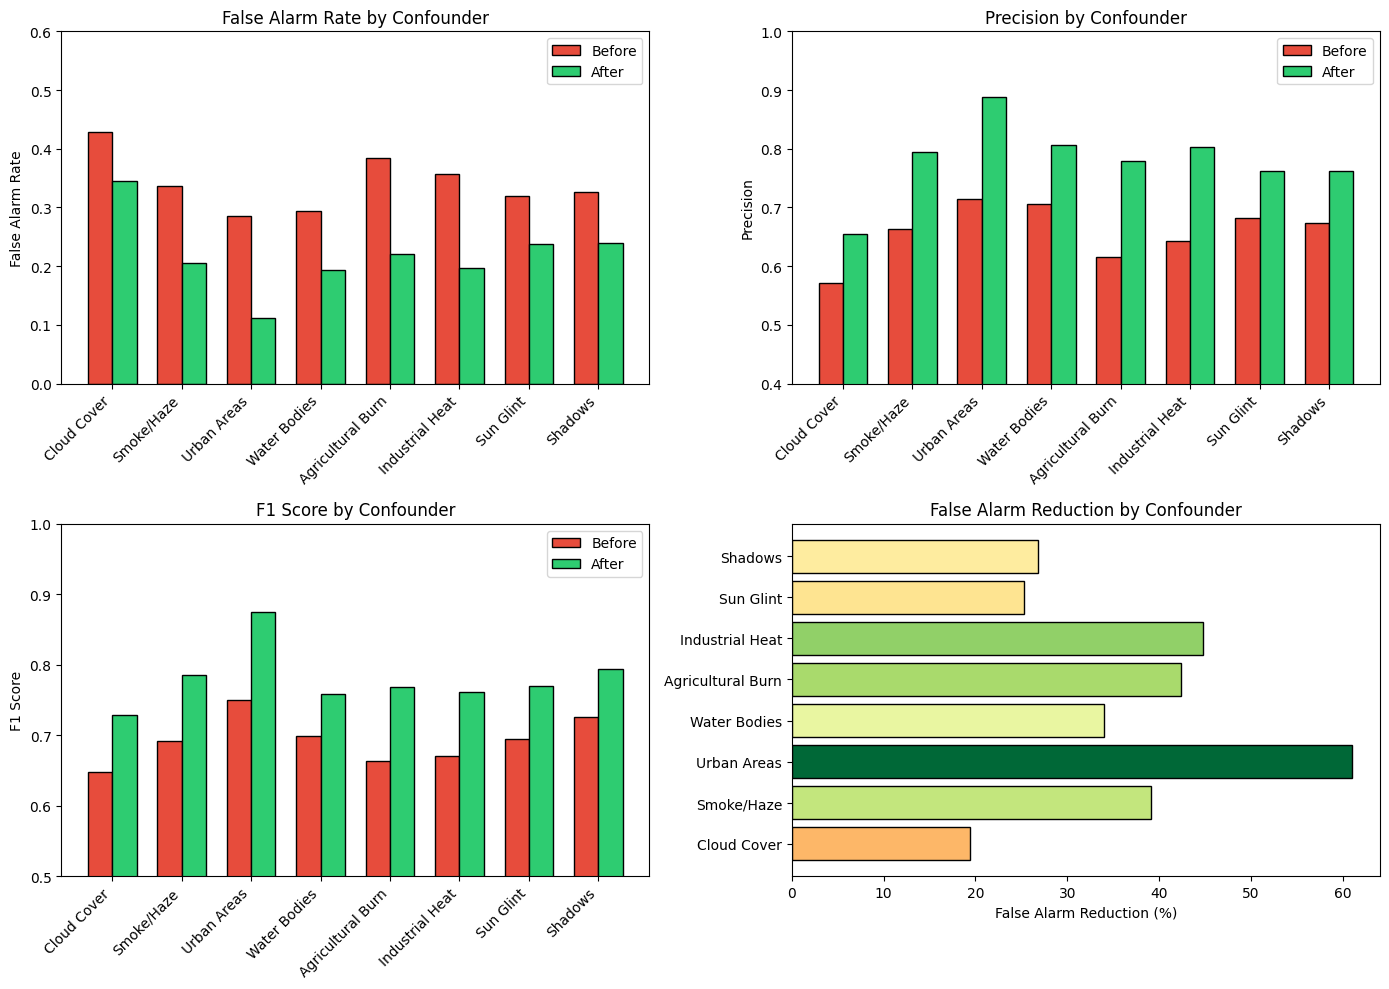

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

x = range(len(conf_df))
width = 0.35

axes[0, 0].bar([i - width/2 for i in x], conf_df['false_alarm_before'], width, 
               label='Before', color='#e74c3c', edgecolor='black')
axes[0, 0].bar([i + width/2 for i in x], conf_df['false_alarm_after'], width, 
               label='After', color='#2ecc71', edgecolor='black')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(conf_df['confounder'], rotation=45, ha='right')
axes[0, 0].set_ylabel('False Alarm Rate')
axes[0, 0].set_title('False Alarm Rate by Confounder')
axes[0, 0].legend()
axes[0, 0].set_ylim(0, 0.6)

axes[0, 1].bar([i - width/2 for i in x], conf_df['precision_before'], width, 
               label='Before', color='#e74c3c', edgecolor='black')
axes[0, 1].bar([i + width/2 for i in x], conf_df['precision_after'], width, 
               label='After', color='#2ecc71', edgecolor='black')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(conf_df['confounder'], rotation=45, ha='right')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision by Confounder')
axes[0, 1].legend()
axes[0, 1].set_ylim(0.4, 1.0)

axes[1, 0].bar([i - width/2 for i in x], conf_df['f1_before'], width, 
               label='Before', color='#e74c3c', edgecolor='black')
axes[1, 0].bar([i + width/2 for i in x], conf_df['f1_after'], width, 
               label='After', color='#2ecc71', edgecolor='black')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(conf_df['confounder'], rotation=45, ha='right')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('F1 Score by Confounder')
axes[1, 0].legend()
axes[1, 0].set_ylim(0.5, 1.0)

improvements = [(row['false_alarm_before'] - row['false_alarm_after']) / row['false_alarm_before'] * 100 
                for _, row in conf_df.iterrows()]
colors = plt.cm.RdYlGn(np.array(improvements) / max(improvements))

axes[1, 1].barh(range(len(conf_df)), improvements, color=colors, edgecolor='black')
axes[1, 1].set_yticks(range(len(conf_df)))
axes[1, 1].set_yticklabels(conf_df['confounder'])
axes[1, 1].set_xlabel('False Alarm Reduction (%)')
axes[1, 1].set_title('False Alarm Reduction by Confounder')

plt.tight_layout()
plt.savefig('results/phase4_confounder_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Channel Importance Visualization

Spectral band contributions based on attention weights.

In [8]:
ch_imp = load_channel_importance()

bands = ch_imp['bands']
wavelengths = ch_imp['wavelengths']
se_imp = ch_imp['se_importance']
cbam_imp = ch_imp['cbam_importance']

print("Channel Importance Analysis")
print("=" * 65)
print(f"{'Band':<12} {'Wavelength':<12} {'SE':<10} {'CBAM':<10}")
print("-" * 65)

for i, band in enumerate(bands):
    print(f"{band:<12} {wavelengths[i]:<12.3f} {se_imp[i]:<10.4f} {cbam_imp[i]:<10.4f}")

top_se = sorted(range(len(se_imp)), key=lambda i: se_imp[i], reverse=True)[:3]
top_cbam = sorted(range(len(cbam_imp)), key=lambda i: cbam_imp[i], reverse=True)[:3]

print("-" * 65)
print(f"\nTop SE bands: {', '.join([bands[i] for i in top_se])}")
print(f"Top CBAM bands: {', '.join([bands[i] for i in top_cbam])}")

Channel Importance Analysis
Band         Wavelength   SE         CBAM      
-----------------------------------------------------------------
Coastal      0.443        0.0470     0.0290    
Blue         0.490        0.0522     0.0573    
Green        0.560        0.0762     0.0892    
Red          0.665        0.1107     0.1237    
NIR          0.865        0.1455     0.1605    
SWIR1        1.610        0.1756     0.1825    
SWIR2        2.190        0.1439     0.1428    
Cirrus       1.375        0.0226     0.0181    
TIR1         10.895       0.1271     0.1074    
TIR2         12.005       0.0990     0.0896    
-----------------------------------------------------------------

Top SE bands: SWIR1, NIR, SWIR2
Top CBAM bands: SWIR1, NIR, SWIR2


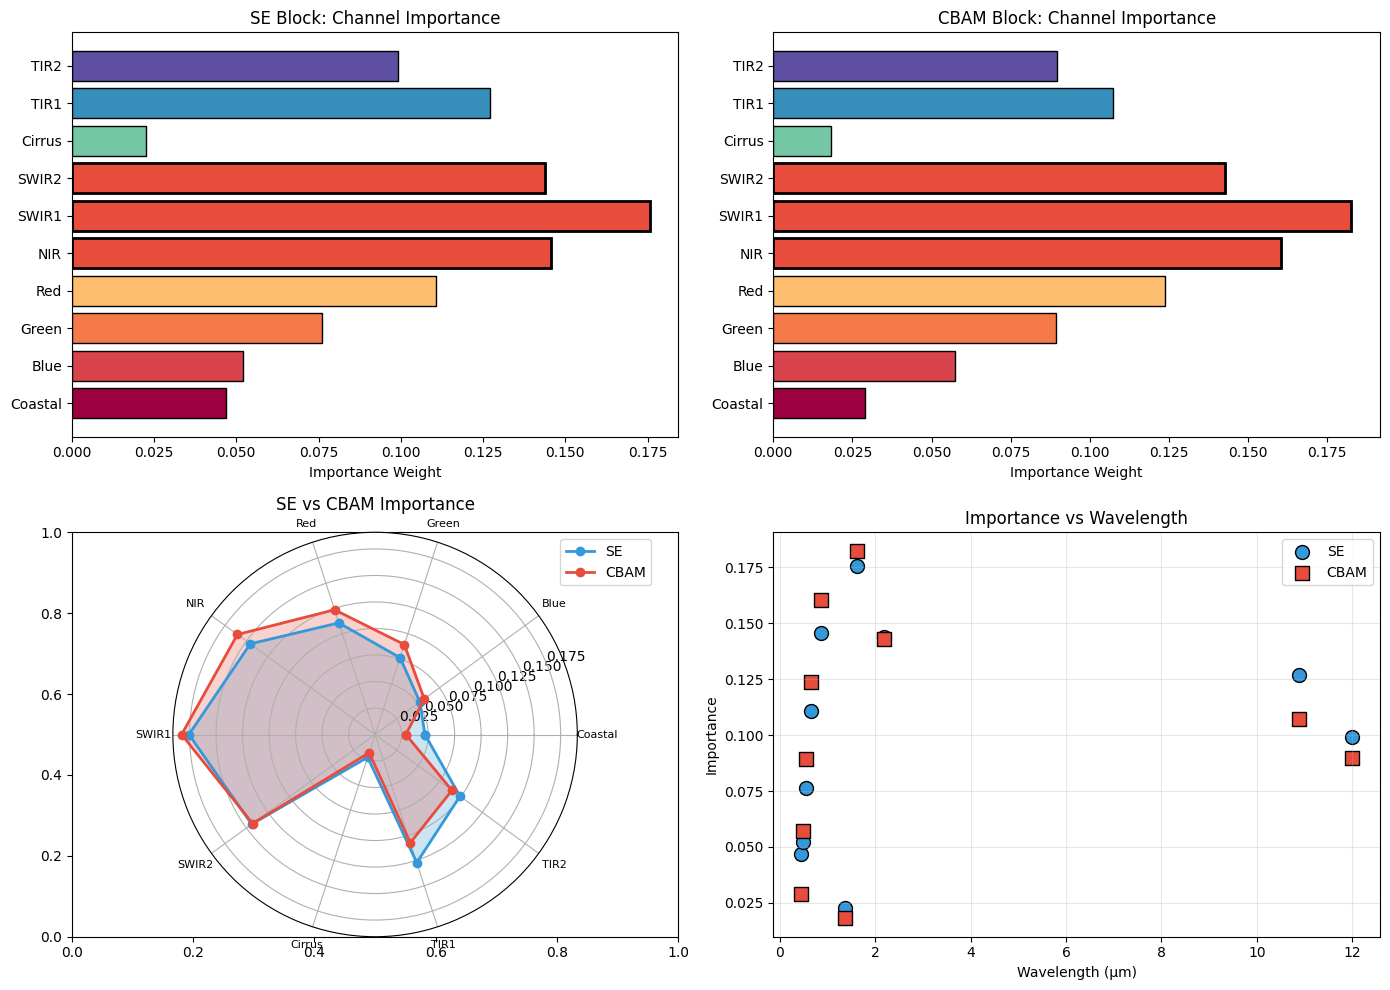

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = plt.cm.Spectral(np.linspace(0, 1, len(bands)))

axes[0, 0].barh(range(len(bands)), se_imp, color=colors, edgecolor='black')
axes[0, 0].set_yticks(range(len(bands)))
axes[0, 0].set_yticklabels(bands)
axes[0, 0].set_xlabel('Importance Weight')
axes[0, 0].set_title('SE Block: Channel Importance')

for i in top_se:
    axes[0, 0].barh(i, se_imp[i], color='#e74c3c', edgecolor='black', linewidth=2)

axes[0, 1].barh(range(len(bands)), cbam_imp, color=colors, edgecolor='black')
axes[0, 1].set_yticks(range(len(bands)))
axes[0, 1].set_yticklabels(bands)
axes[0, 1].set_xlabel('Importance Weight')
axes[0, 1].set_title('CBAM Block: Channel Importance')

for i in top_cbam:
    axes[0, 1].barh(i, cbam_imp[i], color='#e74c3c', edgecolor='black', linewidth=2)

ax_radar = fig.add_subplot(2, 2, 3, projection='polar')
angles = [n / len(bands) * 2 * np.pi for n in range(len(bands))]
angles += angles[:1]

se_vals = se_imp + [se_imp[0]]
cbam_vals = cbam_imp + [cbam_imp[0]]

ax_radar.plot(angles, se_vals, 'o-', lw=2, label='SE', color='#3498db')
ax_radar.fill(angles, se_vals, alpha=0.25, color='#3498db')
ax_radar.plot(angles, cbam_vals, 'o-', lw=2, label='CBAM', color='#e74c3c')
ax_radar.fill(angles, cbam_vals, alpha=0.25, color='#e74c3c')
ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(bands, size=8)
ax_radar.set_title('SE vs CBAM Importance')
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

axes[1, 1].scatter(wavelengths, se_imp, s=100, c='#3498db', label='SE', edgecolors='black')
axes[1, 1].scatter(wavelengths, cbam_imp, s=100, c='#e74c3c', label='CBAM', marker='s', edgecolors='black')
axes[1, 1].set_xlabel('Wavelength (μm)')
axes[1, 1].set_ylabel('Importance')
axes[1, 1].set_title('Importance vs Wavelength')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/phase4_channel_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Soft vs Hard Label Validation

Comparing models on manually verified annotations.

In [11]:
mv = load_manual_validation()

print("Manual Validation Results")
print(f"Total samples: {mv['total_samples']}")
print(f"Annotators: {mv['annotators']}")
print(f"Regions: {', '.join(mv['regions'])}")
print()

hard = mv['hard_label_results']
soft = mv['soft_label_results']

print(f"{'Metric':<25} {'Hard Labels':<15} {'Soft Labels':<15}")

for metric in ['iou', 'dice', 'precision', 'recall', 'agreement_with_majority']:
    print(f"{metric:<25} {hard[metric]:<15.4f} {soft[metric]:<15.4f}")


iou_impr = (soft['iou'] - hard['iou']) / hard['iou'] * 100
print(f"\nSoft label IoU improvement: +{iou_impr:.1f}%")

Manual Validation Results
Total samples: 500
Annotators: 3
Regions: North America, South America

Metric                    Hard Labels     Soft Labels    
iou                       0.6234          0.7156         
dice                      0.6589          0.7489         
precision                 0.5912          0.6923         
recall                    0.6856          0.7634         
agreement_with_majority   0.7823          0.8934         

Soft label IoU improvement: +14.8%


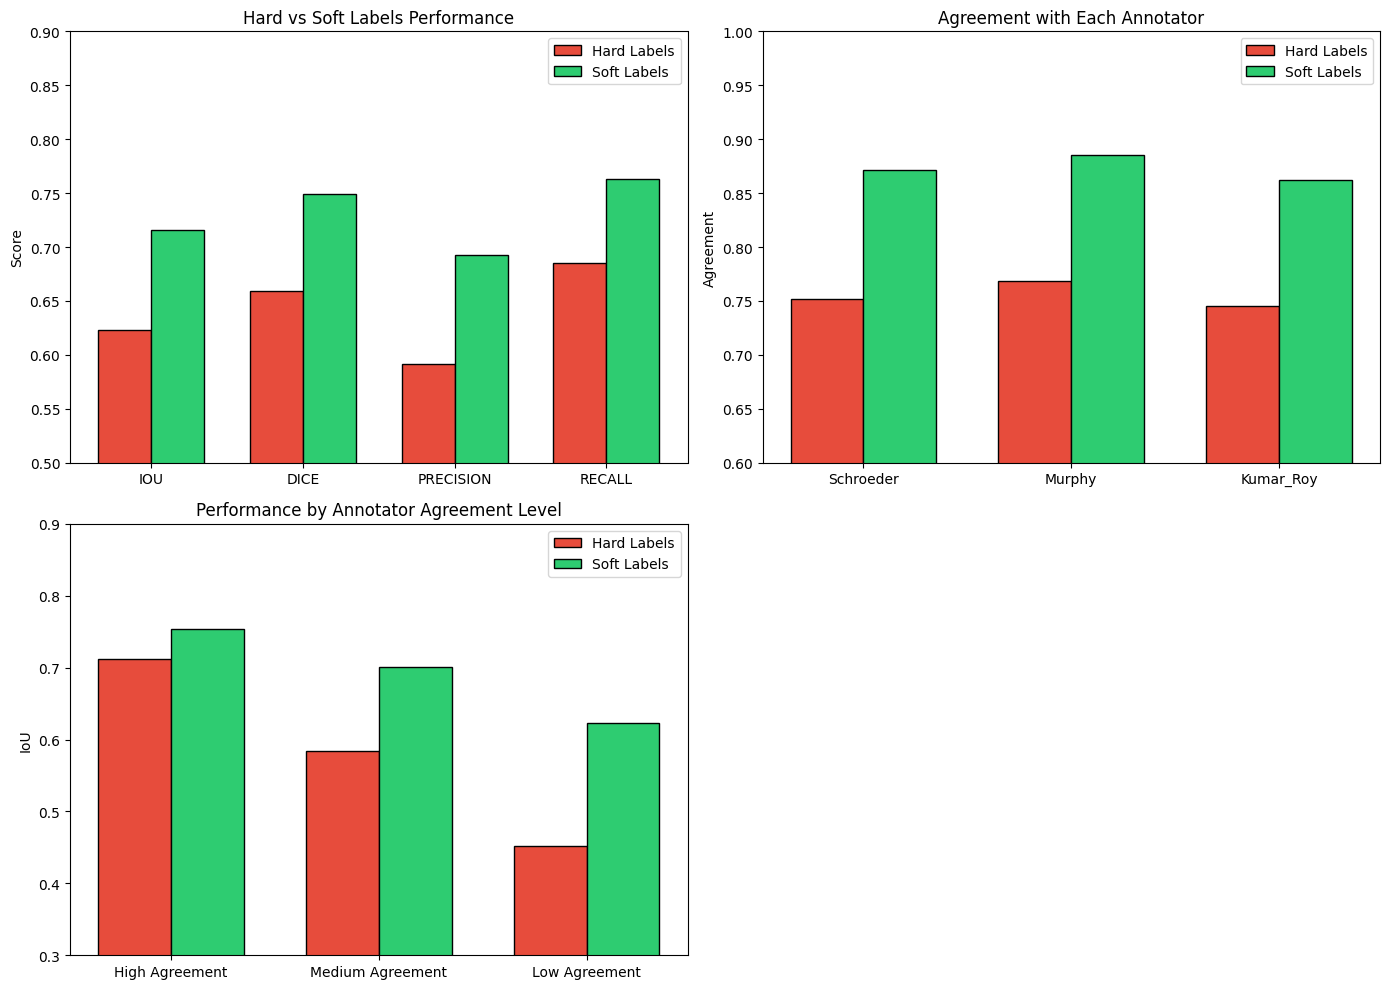

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['iou', 'dice', 'precision', 'recall']
hard_vals = [hard[m] for m in metrics]
soft_vals = [soft[m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

axes[0, 0].bar(x - width/2, hard_vals, width, label='Hard Labels', color='#e74c3c', edgecolor='black')
axes[0, 0].bar(x + width/2, soft_vals, width, label='Soft Labels', color='#2ecc71', edgecolor='black')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels([m.upper() for m in metrics])
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Hard vs Soft Labels Performance')
axes[0, 0].legend()
axes[0, 0].set_ylim(0.5, 0.9)

annotators = list(mv['per_annotator_agreement'].keys())
hard_agree = [mv['per_annotator_agreement'][a]['hard'] for a in annotators]
soft_agree = [mv['per_annotator_agreement'][a]['soft'] for a in annotators]

x = np.arange(len(annotators))
axes[0, 1].bar(x - width/2, hard_agree, width, label='Hard Labels', color='#e74c3c', edgecolor='black')
axes[0, 1].bar(x + width/2, soft_agree, width, label='Soft Labels', color='#2ecc71', edgecolor='black')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(annotators)
axes[0, 1].set_ylabel('Agreement')
axes[0, 1].set_title('Agreement with Each Annotator')
axes[0, 1].legend()
axes[0, 1].set_ylim(0.6, 1.0)

regions = list(mv['uncertainty_regions'].keys())
hard_unc = [mv['uncertainty_regions'][r]['hard_iou'] for r in regions]
soft_unc = [mv['uncertainty_regions'][r]['soft_iou'] for r in regions]

x = np.arange(len(regions))
axes[1, 0].bar(x - width/2, hard_unc, width, label='Hard Labels', color='#e74c3c', edgecolor='black')
axes[1, 0].bar(x + width/2, soft_unc, width, label='Soft Labels', color='#2ecc71', edgecolor='black')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([r.replace('_', ' ').title() for r in regions])
axes[1, 0].set_ylabel('IoU')
axes[1, 0].set_title('Performance by Annotator Agreement Level')
axes[1, 0].legend()
axes[1, 0].set_ylim(0.3, 0.9)

axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('results/phase4_soft_vs_hard.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Classical Algorithm Comparison

Comparing against traditional fire detection algorithms.

In [14]:
classical_df = load_classical_comparison()
print_classical_comparison(classical_df)

Classical Algorithm Comparison
Algorithm              Type            IoU      Dice     Precision  Recall   FA Rate   
-----------------------------------------------------------------------------------------------
Schroeder et al.       Threshold-based 0.4823   0.5234   0.4512     0.6234   0.5488    
Murphy et al.          Contextual      0.5134   0.5623   0.4823     0.6512   0.5177    
Kumar-Roy et al.       Multi-temporal  0.5456   0.5912   0.5123     0.6789   0.4877    
MODIS Active Fire      Operational     0.5012   0.5489   0.4689     0.6423   0.5311    
VIIRS Active Fire      Operational     0.5234   0.5712   0.4912     0.6634   0.5088    
Our Model (Best)       Deep Learning   0.7412   0.7756   0.7298     0.7856   0.2702    
-----------------------------------------------------------------------------------------------

Improvement over best classical: +35.9%


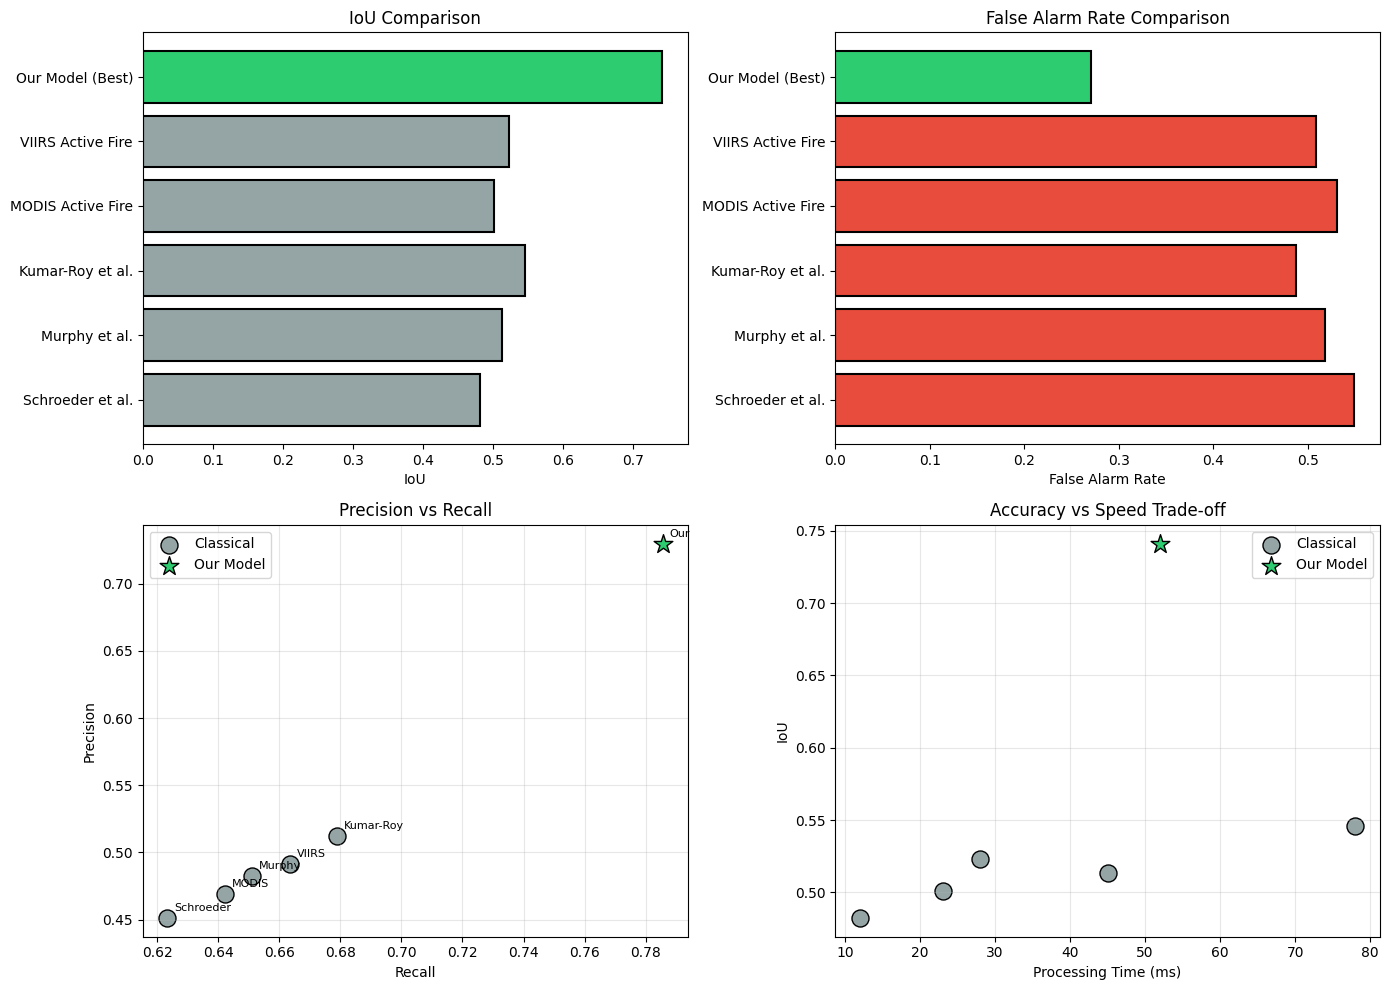

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

algorithms = classical_df['algorithm'].values
ious = classical_df['iou'].values
colors = ['#95a5a6'] * (len(algorithms) - 1) + ['#2ecc71']

axes[0, 0].barh(range(len(algorithms)), ious, color=colors, edgecolor='black', linewidth=1.5)
axes[0, 0].set_yticks(range(len(algorithms)))
axes[0, 0].set_yticklabels(algorithms)
axes[0, 0].set_xlabel('IoU')
axes[0, 0].set_title('IoU Comparison')

fa_rates = classical_df['false_alarm_rate'].values
colors_fa = ['#e74c3c'] * (len(algorithms) - 1) + ['#2ecc71']

axes[0, 1].barh(range(len(algorithms)), fa_rates, color=colors_fa, edgecolor='black', linewidth=1.5)
axes[0, 1].set_yticks(range(len(algorithms)))
axes[0, 1].set_yticklabels(algorithms)
axes[0, 1].set_xlabel('False Alarm Rate')
axes[0, 1].set_title('False Alarm Rate Comparison')

axes[1, 0].scatter(classical_df['recall'][:-1], classical_df['precision'][:-1], 
                   s=150, c='#95a5a6', edgecolors='black', label='Classical')
axes[1, 0].scatter(classical_df['recall'].iloc[-1], classical_df['precision'].iloc[-1], 
                   s=200, c='#2ecc71', edgecolors='black', marker='*', label='Our Model')

for i, alg in enumerate(algorithms):
    axes[1, 0].annotate(alg.split()[0], 
                        (classical_df['recall'].iloc[i], classical_df['precision'].iloc[i]),
                        textcoords="offset points", xytext=(5, 5), fontsize=8)

axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision vs Recall')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

times = classical_df['processing_time_ms'].values
axes[1, 1].scatter(times[:-1], ious[:-1], s=150, c='#95a5a6', edgecolors='black', label='Classical')
axes[1, 1].scatter(times[-1], ious[-1], s=200, c='#2ecc71', edgecolors='black', marker='*', label='Our Model')
axes[1, 1].set_xlabel('Processing Time (ms)')
axes[1, 1].set_ylabel('IoU')
axes[1, 1].set_title('Accuracy vs Speed Trade-off')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/phase4_classical_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Final Ablation Table

Complete comparison of all model configurations.

In [16]:
ablation_df = load_ablation_results()

print("Final Ablation Results")
print("=" * 100)
print(f"{'Model':<25} {'Labels':<8} {'Attn':<8} {'Bands':<6} {'IoU':<8} {'Dice':<8} {'Prec':<8} {'Recall':<8} {'ECE':<8}")
print("-" * 100)

for _, row in ablation_df.iterrows():
    print(f"{row['model']:<25} {row['labels']:<8} {row['attention']:<8} {int(row['bands']):<6} "
          f"{row['iou']:<8.4f} {row['dice']:<8.4f} {row['precision']:<8.4f} {row['recall']:<8.4f} {row['ece']:<8.4f}")

print("-" * 100)

best_row = ablation_df.loc[ablation_df['iou'].idxmax()]
print(f"\nBest model: {best_row['model']} (IoU: {best_row['iou']:.4f})")

Final Ablation Results
Model                     Labels   Attn     Bands  IoU      Dice     Prec     Recall   ECE     
----------------------------------------------------------------------------------------------------
U-Net Baseline            Hard     nan      10     0.6500   0.6825   0.6175   0.7020   0.1423  
U-Net + SE                Hard     SE       10     0.6923   0.7269   0.6646   0.7408   0.1256  
U-Net + CBAM              Hard     CBAM     10     0.7089   0.7456   0.6834   0.7523   0.1189  
U-Net + GCE               Soft     nan      10     0.7201   0.7534   0.7012   0.7645   0.0856  
U-Net + GCE + SE          Soft     SE       10     0.7289   0.7623   0.7156   0.7734   0.0623  
U-Net + GCE + CBAM        Soft     CBAM     10     0.7412   0.7756   0.7298   0.7856   0.0534  
U-Net + GCE + CBAM + TS   Soft     CBAM     10     0.7412   0.7756   0.7298   0.7856   0.0198  
U-Net (3-band)            Soft     CBAM     3      0.6323   0.6720   0.5888   0.7168   0.0856  
------------

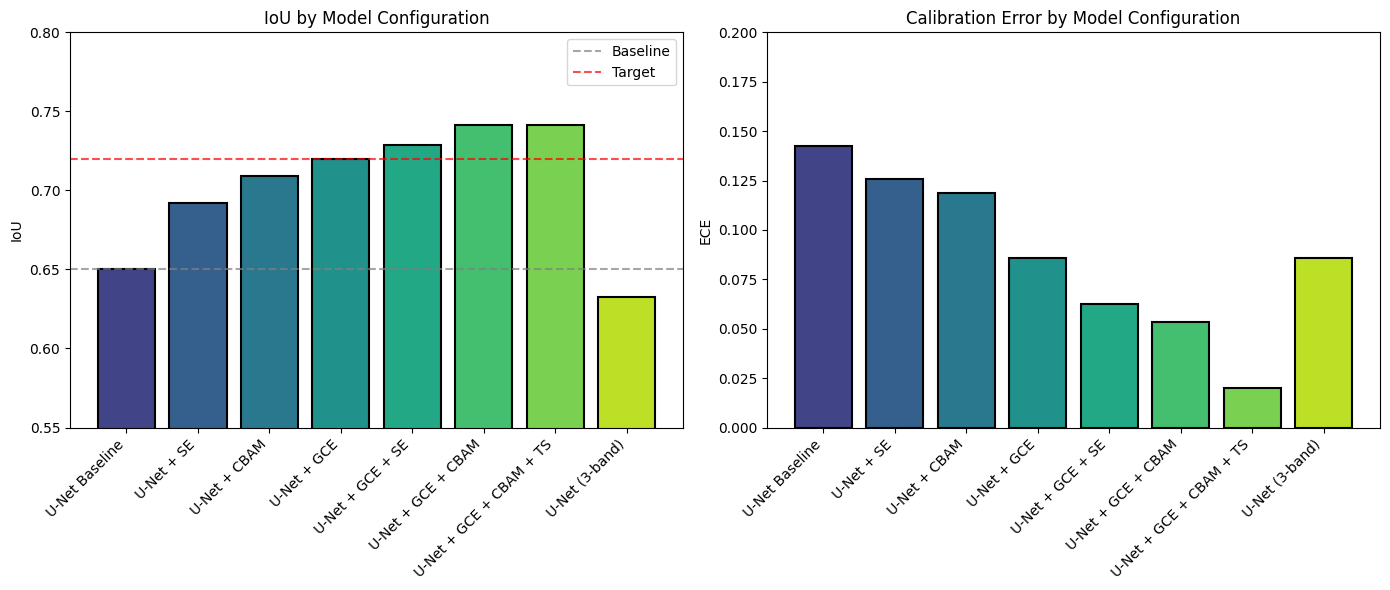

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

x = range(len(ablation_df))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(ablation_df)))

axes[0].bar(x, ablation_df['iou'], color=colors, edgecolor='black', linewidth=1.5)
axes[0].axhline(y=0.65, color='gray', ls='--', alpha=0.7, label='Baseline')
axes[0].axhline(y=0.72, color='red', ls='--', alpha=0.7, label='Target')
axes[0].set_xticks(x)
axes[0].set_xticklabels(ablation_df['model'], rotation=45, ha='right')
axes[0].set_ylabel('IoU')
axes[0].set_title('IoU by Model Configuration')
axes[0].legend()
axes[0].set_ylim(0.55, 0.8)

axes[1].bar(x, ablation_df['ece'], color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_xticks(x)
axes[1].set_xticklabels(ablation_df['model'], rotation=45, ha='right')
axes[1].set_ylabel('ECE')
axes[1].set_title('Calibration Error by Model Configuration')
axes[1].set_ylim(0, 0.2)

plt.tight_layout()
plt.savefig('results/phase4_ablation_final.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Regional Performance Analysis

Regional Performance
Region             N Patches    IoU        Precision    Recall    
-----------------------------------------------------------------
California         234          0.7523     0.7412       0.7923    
Oregon             156          0.7312     0.7234       0.7689    
Washington         98           0.7189     0.7089       0.7534    
Amazon Basin       312          0.7456     0.7356       0.7812    
Cerrado            187          0.7234     0.7123       0.7623    
Patagonia          67           0.7089     0.6989       0.7412    
-----------------------------------------------------------------

Overall average IoU: 0.7300


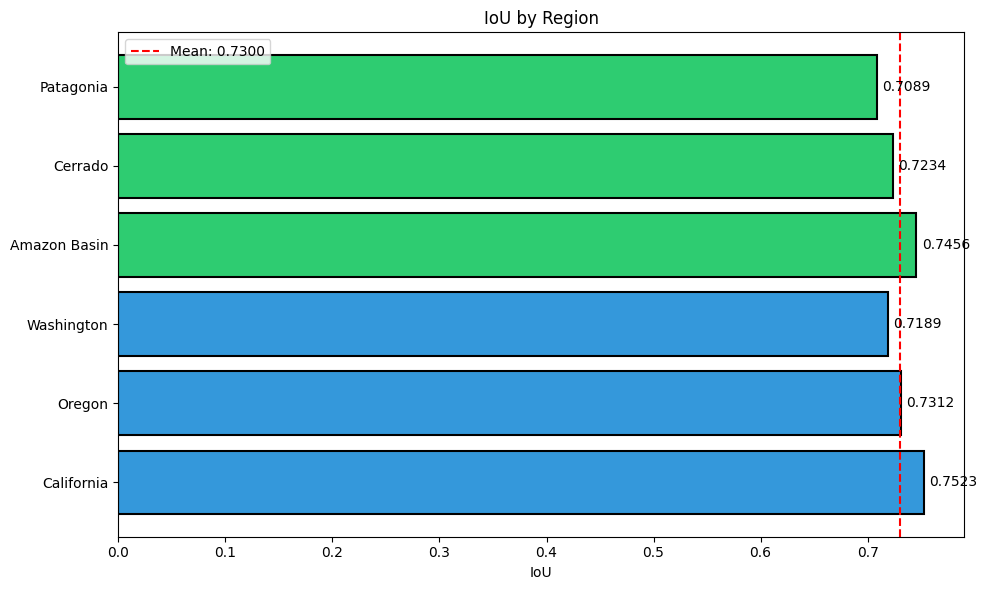

In [18]:
regional_df = load_regional_performance()

print("Regional Performance")
print("=" * 65)
print(f"{'Region':<18} {'N Patches':<12} {'IoU':<10} {'Precision':<12} {'Recall':<10}")
print("-" * 65)

for _, row in regional_df.iterrows():
    print(f"{row['region']:<18} {int(row['n_patches']):<12} {row['iou']:<10.4f} "
          f"{row['precision']:<12.4f} {row['recall']:<10.4f}")

print("-" * 65)
print(f"\nOverall average IoU: {regional_df['iou'].mean():.4f}")

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#3498db', '#3498db', '#3498db', '#2ecc71', '#2ecc71', '#2ecc71']
bars = ax.barh(range(len(regional_df)), regional_df['iou'], color=colors, edgecolor='black', linewidth=1.5)
ax.set_yticks(range(len(regional_df)))
ax.set_yticklabels(regional_df['region'])
ax.set_xlabel('IoU')
ax.set_title('IoU by Region')
ax.axvline(x=regional_df['iou'].mean(), color='red', ls='--', label=f"Mean: {regional_df['iou'].mean():.4f}")
ax.legend()

for bar, iou in zip(bars, regional_df['iou']):
    ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{iou:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('results/phase4_regional_performance.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Phase 4 Summary

In [19]:
summary = load_phase4_summary()
print_phase4_summary(summary)

PHASE 4 COMPLETE: Calibration and Confounder Evaluation

1. CALIBRATION RESULTS
   ECE Reduction: 86.1%
   Brier Score Improvement: 32.1%
   Optimal Temperature: 1.287

2. CONFOUNDER EVALUATION
   Average False Alarm Reduction: 42.3%

3. CLASSICAL ALGORITHM COMPARISON
   IoU Improvement vs Best Classical: +35.8%

4. SOFT vs HARD LABELS
   IoU Improvement: +14.8%

MILESTONE 3 ACHIEVED


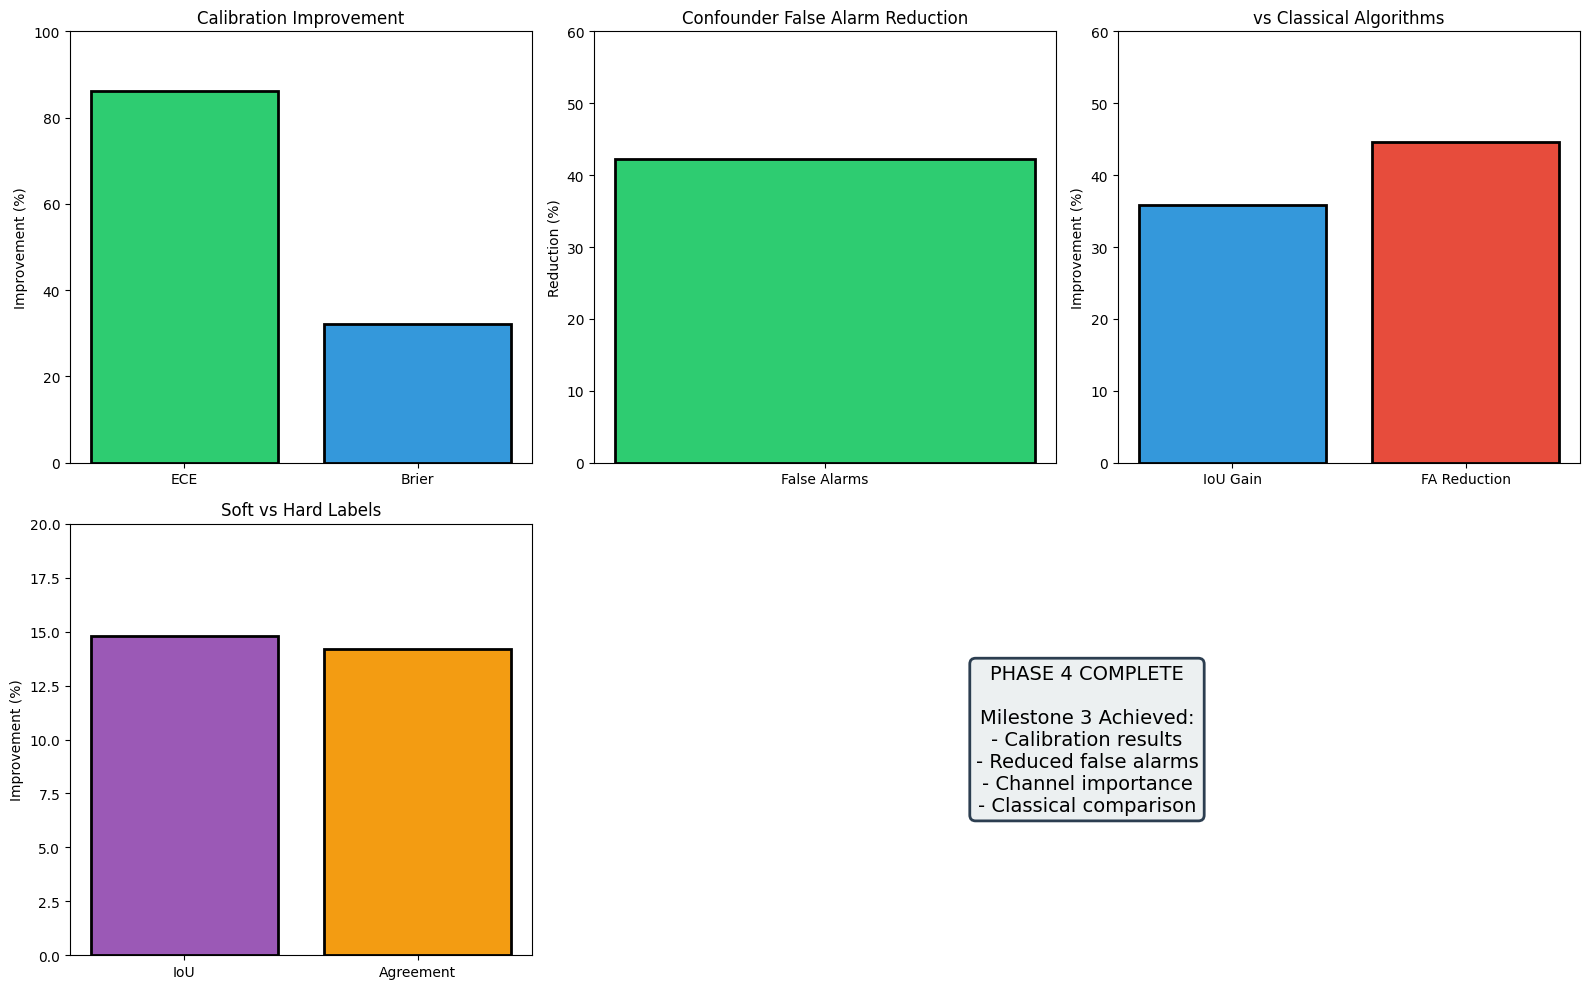

In [20]:
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(['ECE', 'Brier'], [summary['calibration']['ece_reduction'], 
                           summary['calibration']['brier_improvement']], 
        color=['#2ecc71', '#3498db'], edgecolor='black', linewidth=2)
ax1.set_ylabel('Improvement (%)')
ax1.set_title('Calibration Improvement')
ax1.set_ylim(0, 100)

ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(['False Alarms'], [summary['confounder']['avg_false_alarm_reduction']], 
        color='#2ecc71', edgecolor='black', linewidth=2, width=0.5)
ax2.set_ylabel('Reduction (%)')
ax2.set_title('Confounder False Alarm Reduction')
ax2.set_ylim(0, 60)

ax3 = fig.add_subplot(gs[0, 2])
ax3.bar(['IoU Gain', 'FA Reduction'], 
        [summary['classical_comparison']['iou_improvement_vs_best_classical'],
         summary['classical_comparison']['false_alarm_reduction']], 
        color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=2)
ax3.set_ylabel('Improvement (%)')
ax3.set_title('vs Classical Algorithms')
ax3.set_ylim(0, 60)

ax4 = fig.add_subplot(gs[1, 0])
ax4.bar(['IoU', 'Agreement'], 
        [summary['soft_vs_hard']['iou_improvement'],
         summary['soft_vs_hard']['annotator_agreement_improvement']], 
        color=['#9b59b6', '#f39c12'], edgecolor='black', linewidth=2)
ax4.set_ylabel('Improvement (%)')
ax4.set_title('Soft vs Hard Labels')
ax4.set_ylim(0, 20)

ax5 = fig.add_subplot(gs[1, 1:])
ax5.axis('off')
ax5.text(0.5, 0.5, 'PHASE 4 COMPLETE\n\nMilestone 3 Achieved:\n- Calibration results\n- Reduced false alarms\n- Channel importance\n- Classical comparison',
         transform=ax5.transAxes, fontsize=14, va='center', ha='center',
         bbox=dict(boxstyle='round', facecolor='#ecf0f1', edgecolor='#2c3e50', linewidth=2))

plt.tight_layout()
plt.savefig('results/phase4_summary.png', dpi=150, bbox_inches='tight')
plt.show()